In [1]:
from my_tree import *
from random import *

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sympy
import numpy as np
import networkx as nx

In [4]:
x = np.array([1.0004000809 + 1.00005070809])
x.round(6)

array([2.000451])

In [5]:
class GellMann:
    
    def __init__(self, lev_a,lev_b, type_m, d):
        """ Definition taken from https://mathworld.wolfram.com/GeneralizedGell-MannMatrix.html"""
        
        
        
        self.lev_a = lev_a
        self.lev_b = lev_b
        self.type_m = type_m
        self.d=d
        
        self.matrix = np.zeros((d,d),dtype=complex)
        
        if(type_m=='s'):
            
            self.matrix[lev_a,lev_b] = 1
            self.matrix[lev_b,lev_a] = 1
            
        elif(type_m=='a'):
            self.matrix[lev_a,lev_b] -= 1j
            self.matrix[lev_b,lev_a] += 1j
            
        else:
            # lev_a is l in this case
            
            E = np.zeros((d,d))
            
            for j_ind in range(0,lev_b):
                E[j_ind, j_ind] += 1
            
            E[lev_b, lev_b] -= lev_b
            
            coeff= np.sqrt(  2/ ( lev_b*(lev_b + 1) )  )
            
            E = coeff*E
            
            self.matrix = E
            
            
    def m():
        return self.matrix
            


In [6]:
dimension= 2


for i in range(dimension):
    for j in range(i+1,dimension):
        p1 = GellMann(i,j,'s',dimension)
        print('========='+str(i)+str(j)+'============')
        print(p1.matrix)
        
print("@@@@@@@@@@@@@@@@@@@@")

for i in range(dimension):
    for j in range(i+1,dimension):
        p1 = GellMann(i,j,'a',dimension)
        print('========='+str(i)+str(j)+'============')
        print(p1.matrix)
        
print("@@@@@@@@@@@@@@@@@@@@")

for i in range(0,dimension-1):
    p1 = GellMann(i,i+1,'d',dimension)
    print('========='+str(i)+str(j)+'============')
    print(p1.matrix)

=========01============
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
@@@@@@@@@@@@@@@@@@@@
=========01============
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
@@@@@@@@@@@@@@@@@@@@
=========01============
[[ 1.  0.]
 [ 0. -1.]]


In [7]:

####################### ROTATION MATRICES
class custom_Unitary:
    
    def __init__(self, matrix, dimension):
        
        self.d=dimension
        self.matrix = matrix
        
    def cost():
        return np.NAN
        



class R:
    
    def __init__(self,theta,phi,lev_a,lev_b, dimension):
        
        self.theta = theta
        self.phi = phi
        self.lev_a = lev_a
        self.lev_b = lev_b
        self.d=dimension
        
        Identity = np.identity(dimension,dtype='complex')
        
        Identity[lev_a,lev_a] = np.cos(theta/2)*Identity[lev_a,lev_a]
        Identity[lev_b,lev_b] = np.cos(theta/2)*Identity[lev_b,lev_b]

        cosine_matrix = Identity
        
        
        
        self.matrix =  (cosine_matrix -1j*np.sin(theta/2)* 
                        ( np.sin(phi)*GellMann(lev_a,lev_b,'s',dimension).matrix - 
                          np.cos(phi)*GellMann(lev_a,lev_b,'a',dimension).matrix ) )
        
        """control if the matrix is actually correct because different from the slides of Martin, 
            but works as in example"""

    def cost(self):
        E = ( 4*self.theta + 1*abs(np.mod(self.theta +0.25, 0.5) - 0.25) )*10.0e-04
        return E



class Rz:
    
    def __init__(self,theta,lev, dimension):
        
        self.theta = theta
        self.lev = lev
        
        self.d=dimension
        
        Identity = np.identity(dimension,dtype='complex')
        
        Identity[lev,lev]= np.exp(-1j*theta)*Identity[lev,lev]
        self.matrix=Identity
        
    
    def cost(self):
        E = self.theta*10.0e-04
        return E


In [8]:
### not used anymore


from scipy import sparse


def phases_matrix(dim):
    diags = [[1 for x in range(dim)], [-1 for x in range(dim-1)]]
    
    ret = sparse.diags(diags, [0, -1]).toarray()
    
    return np.delete(ret, -1, axis=1)

####################



########################               UTILS

def matmul(f,s):
    dim = f.shape[1]
    rows_s = s.shape[0]
    if(dim!=rows_s):
        raise Exception('not matching dims') 
    mat = [[] for x in range(dim)]
    
    for i in (range(dim)):
        for j in range(dim):
            mat[i].append(f[i,:].dot(s[:,j]))

    return np.array(mat)



def eurlerComplex(phi,A=1):
    return A * ( np.cos(phi) + np.sin(phi)*1j )
   

    
###########################################################
    
def cost_calculator(gate, placement, non_zeros):
    source = gate.lev_a
    target = gate.lev_b
    dist = distance_nodes(placement, source, target)
    
    return ( gate.cost() * dist * non_zeros)

##########################################


# Algorithm


In [9]:


def algorithm(U , initial_placement):
    
    decomp=[]
    #meta_information = []
    #timestamp = 0
    total_cost = 0
    
    U_ = U
    dimension= U.shape[0]
    print("dimension is "+str(dimension))
    

    l=list(range(U.shape[0]))
    l.reverse()
    
    for c in range(U.shape[1]):
        
        diag_index = l.index(c)
        
        for r in l[:diag_index]:

            if( abs(U_[r,c])>1.0e-8 and abs(U_[r-1,c])>1.0e-4  ): ###check error change loop
                
                print("=======================================================")
                print(' r is '+str(r))
                print(' c is '+str(c))
                print("=======================================================")
                
                theta = 2 * np.arctan( abs(U_[r,c]/U_[r-1,c]))
                
                phi = -(np.angle(U_[r-1,c]) - np.angle(U_[r,c]))
                
                print(theta)
                print(phi)
                
                print(U_.round(4))
                
                U_ = matmul(R(theta,phi,r-1,r,dimension).matrix, U_)
                
                print('---')
                print(U_.round(4))
                
                print('@@@@@@@')
                print(R(theta,phi,r-1,r,dimension).matrix.round(4))
                print()
                
                matrix = R(theta,phi,r-1,r,dimension)  
                decomp.append( matrix )
                
                non_zeros = np.count_nonzero(abs(U_)>1.0e-4)
                print("non-zeros:   "+ str(non_zeros))
                estimated_cost = cost_calculator(matrix, initial_placement, non_zeros)
                print("estimated_cost :   "+str(estimated_cost))
                total_cost+= estimated_cost
                #meta_information.append( {rtype:'r', theta: matrix.theta, phi:matrix.phi,lev_a: matrix.lev_a, lev_b:matrix.lev_b, time: timestamp} )
                #timestamp +=1
                
    """Change of plans since the matrices now are sigle entry the linear system is just an identity matrix arg[diag(U)] 
    """
    diag_U = np.diag(U_)
    print("DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD")
    for i in range(dimension):
        
        if( np.angle(diag_U[i]) != 0):
            print("theta rotation")
            print(np.angle(diag_U[i]))
            
            print(U_.round(4))

            U_ = matmul(Rz( np.angle(diag_U[i]), i, dimension).matrix, U_)

            print('---')
            print(U_.round(4))

            print('@@@@@@@')
            print(Rz( np.angle(diag_U[i]), i, dimension).matrix.round(4))
            print('@@@@@@@')
            print()
            
            matrix = Rz( np.angle(diag_U[i]), i, dimension)
            decomp.append( matrix )
            #meta_information.append( {rtype:'rz', theta: matrix.theta, lev: matrix.lev, time: timestamp} )
            #timestamp +=1
        
    print("TOTAL COST")
    print(total_cost)
    return total_cost#decomp

In [10]:
array = np.array([[-1.00+1j , -2.00 ,-3.00, 2.00],[1,2,-3,-4]])
abs(array).sum(axis=0).sum()

18.414213562373096

In [11]:
def Z_extraction(U):
    
    ### CHECK IF MATRIX IS AT LEAST ALMOST DIAGONAL TO OUR CRITERIA
    Ucopy = U.copy()
        
    valid_diag = np.diag(Ucopy).sum() > 1.0e-4

    filtered_Ucopy = Ucopy > 1.0e-4 
    np.fill_diagonal(filtered_Ucopy, 0)

    is_diag = filtered_Ucopy.sum(axis=0).prod()

    if(not (is_diag and valid_diag) ):
        raise Exception('Matrix isnt close to diagonal!')

    
    diag_U = np.diag(U)
    
    print("DDDDDDDDDDDDDiagonal")
    diag_decomp = []
    
    for i in range(dimension):
        
        if( np.angle(diag_U[i]) != 0):
            print("theta rotation")
            print(np.angle(diag_U[i]))
            
            print(U_.round(4))

            U_ = matmul(Rz( np.angle(diag_U[i]), i, dimension).matrix, U_)

            print('---')
            print(U_.round(4))

            print('@@@@@@@')
            print(Rz( np.angle(diag_U[i]), i, dimension).matrix.round(4))
            print('@@@@@@@')
            print()
            diag_decomp.append( Rz( np.angle(diag_U[i]), i, dimension) )
            

        

    return diag_decomp


# GLOBAL TREE == U, cost_max,  current_cost
# INITIAL PLACEMENT

def BFS(current_root):
    

    #######################

    # check if close to diagonal
    Ucopy = current_root.U_of_level.copy()

    #is the diagonal noisy?
    valid_diag = (abs(np.diag(Ucopy))> 1.0e-4).sum() #> 1.0e-4
    print("valid: "+ str(valid_diag))

    # are the non diagonal entries zeroed-out
    filtered_Ucopy = abs(Ucopy) > 1.0e-4 
    np.fill_diagonal(filtered_Ucopy, 0)

    not_diag = filtered_Ucopy.sum(axis=0).sum()
    print("not_diag: "+ str(not_diag))
    ############################################

    if( (not not_diag) and valid_diag ):# if is diagonal enough then somehow signal end of algorithm
        print("condition 2")
        
        print(current_root.U_of_level)
        print(current_root.key)
        
        print("\n\n ARRIVATOOOOOOOOOOOOOOOOOOOOOOO\n\n")
        
        current_root.finished = True
        
        return
        # SALVO UN FLAG SUL FIGLIO 
      
    
    #----------------------------------
    
    
    ## CHECKING FOR BEST CHOICE ON CERTAIN STEP
    U_ = current_root.U_of_level
    
    dimension = U_.shape[0]
    print("dimension is "+str(dimension))
    
    print("checking level")
    for c in range(dimension):

        for r in range(dimension):

            for r2 in range(r, dimension):

                if( abs(U_[r,c])>1.0e-8 and abs(U_[r2,c])>1.0e-4 and r >= c and r2 > r): 


                    print("-------------------------------------------------------------------------")
                    print(' r is '+str(r))
                    print(' r2 is '+str(r2))
                    print(' c is '+str(c))
                    
                    theta = 2 * np.arctan( abs(U_[r2,c]/U_[r,c]))
                    phi = -(np.angle(U_[r2,c]) - np.angle(U_[r,c]))
                    
                    print("theta  : "+str(theta))
                    print("phi  : "+str(phi))
                    
                    rotation_involved = R(theta, phi,r, r2, dimension)
                    
                    U_temp = matmul(  rotation_involved.matrix, U_   )

                    
                    non_zeros = np.count_nonzero(abs(U_temp)>1.0e-4)
                    print("number of non-zeros  :"+ str(non_zeros))
                    
                    
                    estimated_cost = cost_calculator(rotation_involved, initial_placement, non_zeros)
                    print("estimated_cost   :"+str(estimated_cost))
                    print("-------------------------------------------------------------------------")

                    
                    if( (estimated_cost + current_root.current_cost) <= current_root.max_cost): #if cost is better can be only candidate otherwise try them all
                        seed(current_root.key)
                        
                        new_key = random()
                        print(" LA NEW KEY IS : " + str(new_key))
                        current_root.add(new_key, rotation_involved, U_temp, (estimated_cost + current_root.current_cost), current_root.max_cost)
                        
                        
    
    print("next level")
    #===================================================================================
    ## FOR LOOP
    for child in current_root.children:
        BFS(child)
    #===================================================================================
    
    print(current_root.key)

    


# Circuit

In [12]:
################## CIRCUIT

###                  ALL THE CLASSES HAVE TO BE REFACTORED TO FOLLOW DESIGN PATTERNS
"""
class QuantumCircuit:
    
    def __init__(self, qubits, bits, dimension):
        
        self.qubits = list(range(qubits))
        self.bits = list(range(bits))
        self.qreg = [[] for x in range(qubits)] 
        self.reg = [[] for x in range(bits)] 
        self.dimension = dimension
        
    def R(self, qubit_line, theta, phi, lev_a, lev_b ):
        
        self.qreg(qubit_line).append( R(theta,phi,lev_a, lev_b , self.dimension))
        
    def Rz(self, qubit_line, theta, lev):
        
        self.qreg(qubit_line).append( Rz(theta, lev_a, self.dimension))
        
    def custom_unitary(self, qubit_line, unitary):
        
        self.qreg(qubit_line).append( custom_Unitary(unitary, self.dimension) )
        
    #-----------------------------------------------------------------------------
    
    def adjacency_matrix(line):
        
        storage = [[[] for x in range(self.dimension)] for x in range(self.dimension)]
        
        for gate in line:
            
            if(gate[rtype]=='r'):
                
                storage[gate[lev_a]][gate[lev_b]].append([ 'r', gate[theta], gate[phi],gate[time] ])
            
            else:
                
                for row in storage:
                    
                    row[gate[lev]].append(['rz', None, gate[phi],gate[time] ])
                    
                for column in storage[gate[lev]]:
                    
                    column.append(['rz', None, gate[phi],gate[time] ])
                
        
        
        return 
    
    
    def fix_time(gates):
        
        counter = 0
        for i in range(1,len(gates)):
            if(element[i][5] < element[i-1][5]  ):
                counter +=1
                
            element[i][5] += counter
            
        return gates
        
    def propagate_Z(line):
        
        
        return
    
    #----------------------------------------------------------------------------
    
    def simplify(line):
        
        line = fix_time(line)
        
        
        
        
        return
    #-------------------------------------------------------------------------------
    
    def decompose(): #### badly implemented to refactor with functional
        
        for line in qreg:
            
            clean_line = []
            
            for gate in line:
                decomposition = algorithm(gate)[1]
                meta_information = algorithm(gate)[0]
                
                clean_line.append( meta_information )
            
            line = simplify(clean_line)
            
            
            

##############################################

"""

"\nclass QuantumCircuit:\n    \n    def __init__(self, qubits, bits, dimension):\n        \n        self.qubits = list(range(qubits))\n        self.bits = list(range(bits))\n        self.qreg = [[] for x in range(qubits)] \n        self.reg = [[] for x in range(bits)] \n        self.dimension = dimension\n        \n    def R(self, qubit_line, theta, phi, lev_a, lev_b ):\n        \n        self.qreg(qubit_line).append( R(theta,phi,lev_a, lev_b , self.dimension))\n        \n    def Rz(self, qubit_line, theta, lev):\n        \n        self.qreg(qubit_line).append( Rz(theta, lev_a, self.dimension))\n        \n    def custom_unitary(self, qubit_line, unitary):\n        \n        self.qreg(qubit_line).append( custom_Unitary(unitary, self.dimension) )\n        \n    #-----------------------------------------------------------------------------\n    \n    def adjacency_matrix(line):\n        \n        storage = [[[] for x in range(self.dimension)] for x in range(self.dimension)]\n        \n   

# Test

### Cost function

In [13]:
def theta_corrector(angle):

    theta_in_units_of_pi = np.mod( (angle / np.pi), 2)
    filter_n = theta_in_units_of_pi < 0.2
    
    theta_in_units_of_pi[filter_n] =  theta_in_units_of_pi[filter_n]  +  2.0

    return (theta_in_units_of_pi * np.pi)



def cost_test(angolo):
    angolo = theta_corrector(angolo)
    theta_on_units = angolo/np.pi

    E = ( 4*theta_on_units + 1*abs(np.mod(theta_on_units+0.25, 0.5) - 0.25) )*10.0e-04
    
    return E

36.0
35.99675996759968
0.10000100001000009
35.99675996759968
0.8999909999099991


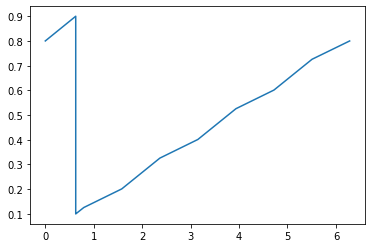

In [14]:
import math

X = np.linspace(0.0, 2*np.pi, 100000)
Y = cost_test(X)*100

print(math.degrees(0.2*np.pi))# pi/5 is the mimum cost in our case


print(math.degrees(X[np.argmax(Y)]))
print(np.min(Y))

print(math.degrees(X[np.argmax(Y)]))
print(np.max(Y))


plt.plot(X, Y)

plt.show()

### Z gates test

In [15]:
from QuantumCircuit import *

QC = QuantumCircuit(3,2,4)

print( R(np.pi/4, np.pi/2 , 0, 1, 4).matrix.round(4) )
print()
print( R(np.pi/4, np.pi/2 -np.pi/5 +np.pi/7 , 0, 1, 4).matrix.round(4) )
print()
print( R(np.pi/4, np.pi , 0, 1, 4).matrix.round(4) )
print()
print( R(np.pi/4, np.pi + np.pi/7 , 0, 1, 4).matrix.round(4) )
print()

[[ 0.9239+0.j      0.    -0.3827j  0.    +0.j      0.    +0.j    ]
 [-0.    -0.3827j  0.9239+0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]

[[ 0.9239+0.j      0.0683-0.3765j  0.    +0.j      0.    +0.j    ]
 [-0.0683-0.3765j  0.9239+0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]

[[ 0.9239+0.j -0.3827-0.j  0.    +0.j  0.    +0.j]
 [ 0.3827-0.j  0.9239+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  1.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  1.    +0.j]]

[[ 0.9239+0.j    -0.3448+0.166j  0.    +0.j     0.    +0.j   ]
 [ 0.3448+0.166j  0.9239+0.j     0.    +0.j     0.    +0.j   ]
 [ 0.    +0.j     0.    +0.j     1.    +0.j     0.    +0.j   ]
 [ 0.    +0.j     0.    +0.j     0.    +0.j     1.    +0.j   ]]



In [16]:
QC.R(0, np.pi/4, np.pi/2, 0, 1  ) #-

QC.Rz(0, np.pi/5, 1 )

QC.R(0, np.pi/4, np.pi, 0, 1  ) #-

QC.Rz(0, np.pi/7, 0 )


In [17]:
for el in QC.qreg[0]:
    
    print("###################")
    print(el.matrix.round(4))
    print(el.theta)
    
    if(isinstance(el, R)):
        print(el.phi)

###################
[[ 0.9239+0.j      0.    -0.3827j  0.    +0.j      0.    +0.j    ]
 [-0.    -0.3827j  0.9239+0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
0.7853981633974483
1.5707963267948966
###################
[[1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.809-0.5878j 0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j    ]]
0.6283185307179586
###################
[[ 0.9239+0.j -0.3827-0.j  0.    +0.j  0.    +0.j]
 [ 0.3827-0.j  0.9239+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  1.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  1.    +0.j]]
0.7853981633974483
3.141592653589793
###################
[[0.901-0.4339j 0.   +0.j     0.   +0.j     0.   +0.j    ]
 [0.   +0.j     1.   +0.j     0.   +0.j     0.   +0.j   

In [18]:
QC.propagate_Z(0)


for el in QC.qreg[0]:
    
    print("###################")
    print(el.matrix.round(4))
    print(el.theta)
    print(el.phi)
    
print("\n\n")


###################
[[ 0.9239+0.j      0.0683-0.3765j  0.    +0.j      0.    +0.j    ]
 [-0.0683-0.3765j  0.9239+0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      1.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.j      1.    +0.j    ]]
0.7853981633974483
1.3912767465897655
###################
[[ 0.9239+0.j    -0.3448+0.166j  0.    +0.j     0.    +0.j   ]
 [ 0.3448+0.166j  0.9239+0.j     0.    +0.j     0.    +0.j   ]
 [ 0.    +0.j     0.    +0.j     1.    +0.j     0.    +0.j   ]
 [ 0.    +0.j     0.    +0.j     0.    +0.j     1.    +0.j   ]]
0.7853981633974483
3.5903916041026207





### Rotation

In [19]:



U= np.array([[0.57735 + 0.00000j ,  0.57735 + 0.00000j,   0.57735 + 0.00000j],
             [0.57735 + 0.00000j,  -0.28868 + 0.50000j , -0.28868 - 0.50000j],
             [0.57735 + 0.00000j,  -0.28868 - 0.50000j , -0.28868 + 0.50000j]],dtype='complex')




#U2=np.array([   [1/np.sqrt(3) , 1/np.sqrt(3) , 1/np.sqrt(3)],[ np.sqrt(2/3), -1/np.sqrt(6), -1/np.sqrt(6)],[ 0, -i/np.sqrt(2) ,i/np.sqrt(2) ] ]).round(5)

U2=   np.array([[0.57735 + 0.00000j ,  0.57735 + 0.00000j ,  0.57735 + 0.00000j],
                [0.81650 + 0.00000j , -0.40825 + 0.00000j , -0.40825 + 0.00000j],
                [0.00000 + 0.00000j , -0.00000 - 0.70711j ,  0.00000 + 0.70711j]],dtype='complex')

print("@@@@@@@@ U")
print(U)
print("@@@@@@@@ U2")
print(U2)

print("@@@@@@@@ inverse")
inverse = U.T.conj()
print(inverse)
print()
print("@@@@@@@@@@@ R12")
mat=matmul(U2,inverse)
      
print(mat)
print()
print("@@@@@@@@@@@@@ U2 from rotation")

print(matmul(mat,U))

@@@@@@@@ U
[[ 0.57735+0.j   0.57735+0.j   0.57735+0.j ]
 [ 0.57735+0.j  -0.28868+0.5j -0.28868-0.5j]
 [ 0.57735+0.j  -0.28868-0.5j -0.28868+0.5j]]
@@@@@@@@ U2
[[ 0.57735+0.j       0.57735+0.j       0.57735+0.j     ]
 [ 0.8165 +0.j      -0.40825+0.j      -0.40825+0.j     ]
 [ 0.     +0.j      -0.     -0.70711j  0.     +0.70711j]]
@@@@@@@@ inverse
[[ 0.57735-0.j   0.57735-0.j   0.57735-0.j ]
 [ 0.57735-0.j  -0.28868-0.5j -0.28868+0.5j]
 [ 0.57735-0.j  -0.28868+0.5j -0.28868-0.5j]]

@@@@@@@@@@@ R12
[[ 9.99999068e-01+0.j -5.77350000e-06+0.j -5.77350000e-06+0.j]
 [ 0.00000000e+00+0.j  7.07113495e-01+0.j  7.07113495e-01+0.j]
 [ 0.00000000e+00+0.j -7.07110000e-01+0.j  7.07110000e-01+0.j]]

@@@@@@@@@@@@@ U2 from rotation
[[ 0.57734279+0.j       0.5773528 +0.j       0.5773528 +0.j     ]
 [ 0.81650395+0.j      -0.40825905+0.j      -0.40825905+0.j     ]
 [ 0.        +0.j       0.        -0.70711j  0.        +0.70711j]]


In [20]:

theta = 2 * np.arctan( abs(U[2,0]/U[1,0]))
                
phi = -(np.angle(U[1,0])- np.angle(U[2,0]))

print(theta)
print(phi)

p = R(theta,phi,1,2,3).matrix.round(6)
print(p)


print("@@@@@@ trying to get U2")
test= matmul(p,U)
print(test)

1.5707963267948966
-0.0
[[ 1.      +0.j  0.      +0.j  0.      +0.j]
 [ 0.      +0.j  0.707107+0.j  0.707107+0.j]
 [ 0.      +0.j -0.707107+0.j  0.707107+0.j]]
@@@@@@ trying to get U2
[[ 0.57735   +0.j        0.57735   +0.j        0.57735   +0.j      ]
 [ 0.81649645+0.j       -0.4082553 +0.j       -0.4082553 +0.j      ]
 [ 0.        +0.j        0.        -0.707107j  0.        +0.707107j]]


In [21]:
pz = Rz(theta,0,3)
print(pz.matrix)
print(pz.cost())


[[6.123234e-17-1.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j]]
0.0005


In [22]:
# commutation between different coupling rotations

U= np.array([[0.57735 + 0.00000j ,  0.57735 + 0.00000j,   0.57735 + 0.00000j],
             [0.57735 + 0.00000j,  -0.28868 + 0.50000j , -0.28868 - 0.50000j],
             [0.57735 + 0.00000j,  -0.28868 - 0.50000j , -0.28868 + 0.50000j]],dtype='complex')

print(U)
print()
###################################################

theta_12 = 2 * np.arctan( abs(U[2,1]/U[1,1]))
                
phi_12 = -(np.angle(U[1,1])- np.angle(U[2,1]))

rot12 = R(theta_12,phi_12,1,2,3).matrix.round(6)

int1 = matmul(rot12,U)
print(int1.round(6))
print()
#------------------------------------------------

theta_01 = 2 * np.arctan( abs(int1[1,1]/int1[0,1]))
                
phi_01 = -(np.angle(int1[1,1])- np.angle(int1[0,1]))

rot01 = R(theta_01,phi_01,0,1,3).matrix.round(6)

int2 = matmul(rot01, int1)
#-------------------------------------------------
print(int2.round(6))
print()

######################################################
theta_01 = 2 * np.arctan( abs(U[1,1]/U[0,1]))
                
phi_01 = -(np.angle(U[1,1])- np.angle(U[0,1]))

rot01 = R(theta_01,phi_01,0,1,3).matrix.round(6)

int1 = matmul(rot01, U)
print(int1.round(6))
print()

##-------------------------------------------------

theta_12 = 2 * np.arctan( abs(int1[2,1]/int1[1,1]))
                
phi_12 = -(np.angle(int1[1,1])- np.angle(int1[2,1]))

rot12 = R(theta_12,phi_12,1,2,3).matrix.round(6)

int2 = matmul(rot12, int1)
#---------------------------------------------------
print(int2.round(6))
print()



[[ 0.57735+0.j   0.57735+0.j   0.57735+0.j ]
 [ 0.57735+0.j  -0.28868+0.5j -0.28868-0.5j]
 [ 0.57735+0.j  -0.28868-0.5j -0.28868+0.5j]]

[[ 0.57735 +0.j        0.57735 +0.j        0.57735 +0.j      ]
 [ 0.20413 -0.353556j -0.408256+0.707107j  0.204122-0.353544j]
 [ 0.612367-0.353556j  0.      -0.j       -0.612378+0.353563j]]

[[ 4.99997e-01+0.288682j  5.00000e-06-0.577359j  4.99991e-01+0.288672j]
 [ 3.53559e-01+0.204122j -0.00000e+00+0.816494j  3.53555e-01+0.204129j]
 [ 6.12367e-01-0.353556j  0.00000e+00-0.j       -6.12378e-01+0.353563j]]

[[ 0.20412 +0.353552j  0.204127-0.353559j  0.816498+0.j      ]
 [ 0.612374+0.353552j  0.      +0.707105j  0.      -0.j      ]
 [ 0.57735 +0.j       -0.28868 -0.5j      -0.28868 +0.5j     ]]

[[ 0.20412 +3.53552e-01j  0.204127-3.53559e-01j  0.816498+0.00000e+00j]
 [ 0.158114+9.12830e-02j  0.      +9.12872e-01j  0.316233-1.82571e-01j]
 [ 0.894429-4.00000e-06j -0.      +0.00000e+00j -0.22361 +3.87297e-01j]]



In [23]:

u1=np.array([[ 1.    -0.j    ,  0.    +0.j     ,   0.    +0.j    ],
             [ 0.    -0.j    ,  -0.7072-0.j    ,  -0.7072-0.j    ],
             [ 0.    +0.j    ,  0.    -0.7071j ,  0.    +0.7071j]])

u2=np.array([[ 1.0000e+00+0.j  ,    0.0000e+00+0.j   ,   0.0000e+00+0.j    ],
             [ 0.0000e+00+0.j  ,   -1.0001e+00+0.j  ,   -1.0000e-04+0.j    ],
             [ 0.0000e+00+0.j  ,    0.0000e+00-0.j  ,    0.0000e+00+1.0001j]])


theta = 2 * np.arctan( abs(u1[2,1]/u1[1,1]))
                
phi = -( np.angle(u1[1,1])- np.angle(u1[2,1]))

print(theta)
print(phi)

p = R(theta, phi, 1,2,3).matrix
print(p.round(6))

print("@@@@@@ trying to get U2")
test= matmul(p,u1)
print(test.round(4))

1.570654914082129
-4.71238898038469
[[ 1.      +0.j        0.      +0.j        0.      +0.j      ]
 [ 0.      +0.j        0.707157+0.j       -0.      -0.707057j]
 [ 0.      +0.j        0.      -0.707057j  0.707157+0.j      ]]
@@@@@@ trying to get U2
[[ 1.0000e+00+0.j      0.0000e+00+0.j      0.0000e+00+0.j    ]
 [ 0.0000e+00+0.j     -1.0001e+00+0.j     -1.0000e-04-0.j    ]
 [ 0.0000e+00+0.j     -0.0000e+00-0.j     -0.0000e+00+1.0001j]]


## End test

In [24]:
"""TOTAL COST 0.020439836440503525"""

'TOTAL COST 0.020439836440503525'

In [25]:
"""TOTAL COST 0.030570763426890545"""

'TOTAL COST 0.030570763426890545'

### Initial Placement

In [26]:

def level_Graph(edges, nodes_number):
    
    G = nx.Graph()
    G.add_nodes_from(list(range(nodes_number)))
    G.add_edges_from(edges)
    
    return G

def distance_nodes(G, source, target):
    path = nx.shortest_path(G, source, target)
    return len(path)-1

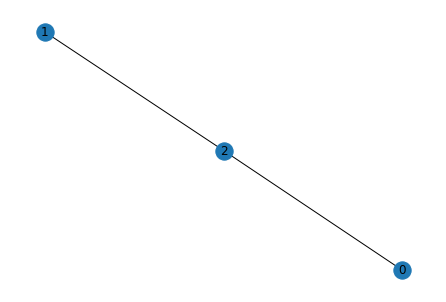

In [27]:
dimension = 3
edges = [(0,2),(2,1)]

initial_placement = level_Graph(edges, dimension)

nx.draw(initial_placement, with_labels = True)

### -----------

In [28]:



cost_limit = algorithm(U , initial_placement)



print("\n\n\n\n\n\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")

TREE = N_ary_Tree()
TREE.add(0, np.identity(3,dtype='complex'), U, 0, cost_limit)


BFS(TREE.root)

print(TREE.print_tree(TREE.root,"ZIOBELLO"))

print("\n\n\n\n\n\n&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")















dimension is 3
 r is 2
 c is 0
1.5707963267948966
-0.0
[[ 0.5774+0.j   0.5774+0.j   0.5774+0.j ]
 [ 0.5774+0.j  -0.2887+0.5j -0.2887-0.5j]
 [ 0.5774+0.j  -0.2887-0.5j -0.2887+0.5j]]
---
[[ 0.5774+0.j      0.5774+0.j      0.5774+0.j    ]
 [ 0.8165+0.j     -0.4083+0.j     -0.4083-0.j    ]
 [ 0.    +0.j     -0.    -0.7071j -0.    +0.7071j]]
@@@@@@@
[[ 1.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.7071+0.j]
 [ 0.    +0.j -0.7071+0.j  0.7071+0.j]]

non-zeros:   8
estimated_cost :   0.016
 r is 1
 c is 0
1.9106332362490186
-0.0
[[ 0.5774+0.j      0.5774+0.j      0.5774+0.j    ]
 [ 0.8165+0.j     -0.4083+0.j     -0.4083-0.j    ]
 [ 0.    +0.j     -0.    -0.7071j -0.    +0.7071j]]
---
[[ 1.    +0.j     -0.    +0.j     -0.    -0.j    ]
 [ 0.    +0.j     -0.7071+0.j     -0.7071-0.j    ]
 [ 0.    +0.j     -0.    -0.7071j -0.    +0.7071j]]
@@@@@@@
[[ 0.5774+0.j  0.8165+0.j  0.    +0.j]
 [-0.8165+0.j  0.5774+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  1.    +0.j]]

non-zeros:   5